# Speech Emotion Classification

Emotion Analysis is a widely used in many industries. Companies providing online services use it to analyse customer feedback. In clinical investigation, it is used to predict the state of the patients. In the Human Resources Departments, it is used for applications like attrition prediction, etc. In Insurance industry, it is used for detecting fraud. There are many more use cases for emotion analysis.

Emotion Analysis is generally conducted on Text data. This is a field of Natural Language Processing (NLP). In this field, the different words are analysed to determine the sentiment and/or emotion. In this article, we discuss emotion analysis from speech. Here, the aspects like pitch, tone, speaking pace, loudness, etc. are analysed to decide the emotion expressed in a speech.

Detecting emotions from speech requires machine learning. This field is still in its nascent stage as there are not too many reliable datasets available for building good machine learning models. In this article, we discuss the mechanics of building such models. The models can be improved by supplying better quality data to the model and/or improving the model itself.

## Dataset

The datasets used in this article have been obtained from [Kaggle](https://www.kaggle.com).

**TESS Dataset**

The first dataset used in this article is the [TESS](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF) (Toronto emotional speech set) dataset. It contains 2880 files.  A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses and the sets were recorded in seven different emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). Both actresses spoke English as their first language, were university educated, and had musical training. Audiometric testing indicated that both actresses had thresholds within the normal range.

**Ravdess Dataset**

The second dataset used in this article is [Ravdess](https://zenodo.org/record/1188976#.YLczy4XivIU) (The Ryerson Audio-Visual Database of Emotional Speech and Song). This dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions include calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: `03-01-06-01-02-01-12.wav`

    - Audio-only - 03
    - Speech - 01
    - Fearful - 06
    - Normal intensity - 01
    - Statement "dogs" - 02
    - 1st Repetition - 01
    - 12th Actor - 12 Female, as the actor ID number is even.

**Links to download the datasets**

To obtain the Tess and Rav Datasets, [click](https://drive.google.com/file/d/1Pj9XrfhEY7X36hQdmIQsuZRfMLHgzE_i/view?usp=sharing) this link.

To obtain the Test Dataset, [click](https://drive.google.com/file/d/1Ep3mOQOrZc-2aI03Gu6SwFfOd_xhMZbl/view?usp=sharing) this link.

## Information

**Librosa**

[Librosa](https://librosa.org/doc/latest/index.html) is a Python package, built for speech and audio analytics. It provides modular functions that simplify working with audio data and help in achieving a wide range of applications such as the identification of the personal characteristics of different individuals' voice samples, the detection of emotions from audio samples etc. 

For further details on the Librosa package, refer [here](https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf).


## Building the Model

Now we start building our model for extracting emotions from the audio files.


### Loading the Tess data and Ravdess data audio files

We start by loading the datasets. Using the links provided in the preceding section, one would get zipped files containing the audio files. The ZIP files need to be unzipped before proceeding to the next step.

We use the **glob** library in Python to load the files. The appropriate path where the files in the dataset have been downloaded will need to be provided to the **glob()** function. In my case, the files are stored in the same directory where my Jupyter Notebook is stored.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob

tessFiles = glob.glob('./Ravdess_Tess/Tess/**/*.wav', recursive = True)
ravdessFiles = glob.glob('./Ravdess_Tess/ravdess/**/*.wav', recursive = True)

print("Number of Tess Files loaded:", len(tessFiles))
print("Number of Ravdess Files loaded:", len(ravdessFiles))

Number of Tess Files loaded: 2679
Number of Ravdess Files loaded: 1168


**Play sample audios**

Once the data (audio files) are loaded, we can play them using the code as follows.

In [3]:
import IPython.display as ipd

sampleAudio1 = ravdessFiles[0]
ipd.Audio(sampleAudio1)

In [4]:
sampleAudio2 = tessFiles[100]
ipd.Audio(sampleAudio2)

### Exploring and Visualising the data

From the dataset, we need to first establish the distribution of the data. Distribution of the data is a key aspect of building a good model. We know that the data contains audio clips of 8 different emotions. We need to check whether the number of audio files in the dataset for each emotion is similar or dissimilar. If the number of audio files for each emotion is similar, then we would say that the dataset is balanced. Otherwise, the dataset would be termed as unbalanced.

If the dataset is balanced, then the model would give almost equal weight to each emotion. If this is not the case, the model could be biased towards the emotion where a greater number of audio clips are available.

In case the dataset is unbalanced, we can balance the dataset algorithmically. We will discuss this later in the article.

#### Visualise the distribution of all the labels

We first establish how many audio clips we have for each emotion. Here, the emotion expressed in the audio clips is our label. We will tell the machine that a particular audio clip expresses a particular emotion. Based on this knowledge provided to the machine, the machine would be expected to learn how to determine the emotion expressed in a new audio clip provided to the machine.

The emotion associated with each audio clip is encoded in the file name of the audio clip as has been described earlier. The following code extracts the text associated with the emotion from the file name and associates it with the audio clip. Please note that the file naming convention for the Tess files and the Rav files is different. Also, note that the variables **tessFiles** and **ravFiles** contains the full path of the all the audio clip files.

In [5]:
emotionsInTessFiles = [fileName.split("/")[-1].split("_")[-1].split(".")[0].lower() for fileName in tessFiles]
emotionsInRavdessFiles = [fileName.split("/")[-1].split("_")[-1].split(".")[0].lower() for fileName in ravdessFiles]

We now check the emotions are available in Tess Files and Rav files.

In [6]:
print('Emotions available in Tess Files:', set(emotionsInTessFiles))
print('Emotions available in Ravdess Files:', set(emotionsInRavdessFiles))

Emotions available in Tess Files: {'disgust', 'surprised', 'fear', 'angry', 'happy', 'neutral', 'sad'}
Emotions available in Ravdess Files: {'disgust', 'surprised', 'fear', 'angry', 'happy', 'neutral', 'sad'}


Notice that we  have no samples are the emotion **calm**. We cannot determine the emotion calm from the model we will build using this data set.

Next, let us count how many audio files for each emotion are available in the 2 datasets.

In [7]:
import pandas as pd

print('Number of Audio Clips available for each Emotion in the Tess Files')
dfTessEmotions = pd.DataFrame(emotionsInTessFiles, columns = ['Emotion'])
dfTessCount = dfTessEmotions.value_counts().reset_index(name = 'count')
dfTessCount

Number of Audio Clips available for each Emotion in the Tess Files


,Emotion,count
0,disgust,391
1,surprised,387
2,happy,383
3,angry,382
4,fear,379
5,sad,379
6,neutral,378


In [8]:
print('Number of Audio Clips available for each Emotion in the Rav Files')
dfRavdessEmotions = pd.DataFrame(emotionsInRavdessFiles, columns = ['Emotion'])
dfRavdessCount = dfRavdessEmotions.value_counts().reset_index(name = 'count')
dfRavdessCount

Number of Audio Clips available for each Emotion in the Rav Files


,Emotion,count
0,sad,183
1,fear,182
2,surprised,182
3,disgust,180
4,angry,179
5,happy,174
6,neutral,88


In [9]:
print('Number of Audio Clips available for each Emotion in both the Tess and Rav Files combined together')
dfCombined = dfTessEmotions.append(dfRavdessEmotions)
dfCombinedCount = dfCombined.value_counts().reset_index(name = 'count')
dfCombinedCount

Number of Audio Clips available for each Emotion in both the Tess and Rav Files combined together


,Emotion,count
0,disgust,571
1,surprised,569
2,sad,562
3,angry,561
4,fear,561
5,happy,557
6,neutral,466


As we will be building the model by combining the TESS and Ravdess datasets, let us see the distribution of the number of audio clips across the different emotions for the combined data set.

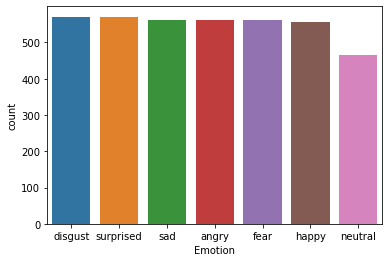

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

sb.barplot(x = dfCombinedCount['Emotion'], y = dfCombinedCount['count'])
plt.show()

We see that we have more or less the same number of files for all emotions except the neutral emotion. We will proceed as it is now. Later we will see how we can balance the dataset.

#### Visualize sample audio signal using librosa

We will now visualize audio signals in the audio files. To do this, we will use the **librosa** library.

In most cases, the librosa library may need to be installed. Use the following code to install the librosa library on your machine. To be able to install the librosa library on your machine, you would need the **numba** library in version of at least 0.53 (This is at the time of writing this article). Check whether you have the appropriate version of the numba library installed on your machine. The following code installs the numba library and then installs the librosa library for safety.

In [11]:
!pip -qq install numba
!pip -qq install librosa

Now, we can use the librosa library to visualize the wave form in the audio files.

Before we can visualize the wave form, we need to load the audio clip. Audio Clips are a Time Series which has frequencies at different points in time.

An audio time series is in the form of a 1-dimensional array for mono or in the form of a 2-dimensional array for stereo, along with a time sampling rate (which defines the length of the array), where the elements within each of the arrays represent the amplitude of the sound waves is returned by `librosa.load()` function.

For the Physics enthusiasts, the frequency and amplitude of a wave form are inversely proportional.

**librosa.load()** function loads an audio file and decodes it into a 1-dimensional array (for mono) which is a time series X, and sr is a sampling rate of X. Default sr is 22kHz.

In [12]:
import librosa

X, samplingRate = librosa.load(sampleAudio1)
print('X\n', X)
print('\nNumber of elements in X:', len(X))
print('Sampling Rates:', samplingRate)

X
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.3070108e-05
 -3.5594071e-06  0.0000000e+00]

Number of elements in X: 91231
Sampling Rates: 22050


Now we plot the waveform for the sample audio clip.

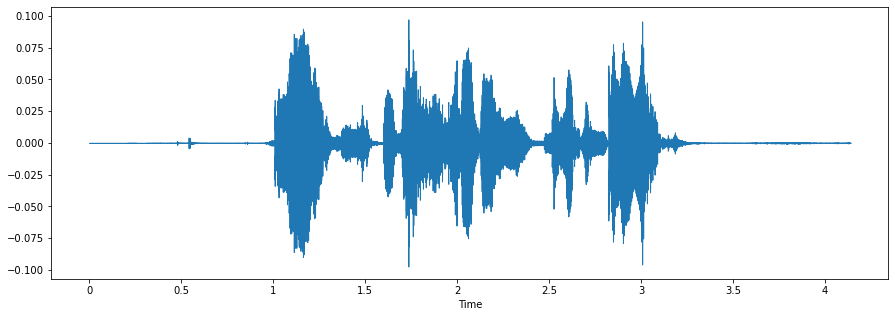

In [13]:
import librosa.display

plt.figure(figsize=(15, 5))
librosa.display.waveshow(X, sr = samplingRate)
plt.show()

We will display the wave form for another sample audio clip.

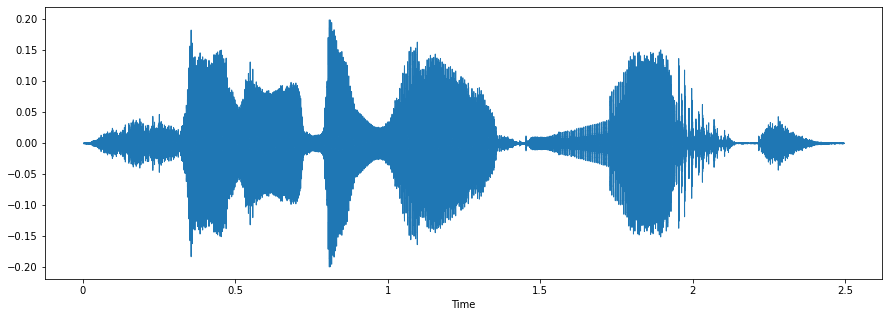

In [14]:
X, samplingRate = librosa.load(sampleAudio2, mono = False)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(X, sr = samplingRate)
plt.show()

### Extracting Features

Next we need to extract the features from the audio clips. For extracting the features from the audio files, we will use the **librosa** library. We will take one audio clip and apply individual functions in the librosa library to see what features we extract.

#### Load the Audio Clip

The first step is to load the audio clip using the **librosa.load()** function.


Read one WAV file at a time using `Librosa`.

To know more about Librosa, explore the [link](https://librosa.org/doc/latest/feature.html)

X
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.3070108e-05
 -3.5594071e-06  0.0000000e+00]

Number of elements in X: 91231
Sampling Rates: 22050


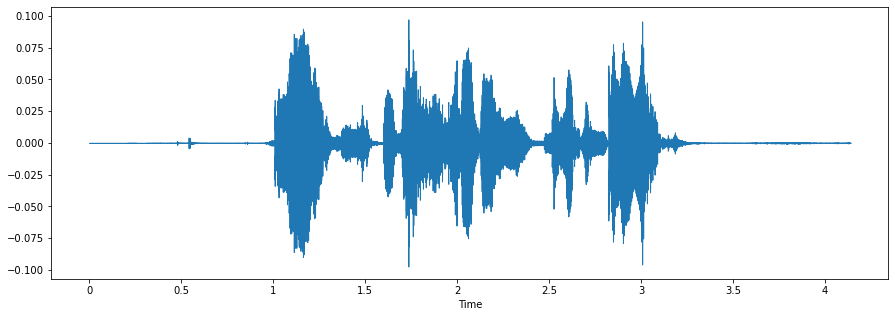

In [15]:
X, samplingRate = librosa.load(sampleAudio1)
print('X\n', X)
print('\nNumber of elements in X:', len(X))
print('Sampling Rates:', samplingRate)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(X, sr = samplingRate)
plt.show()

#### Pre-Emphasis

The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. A pre-emphasis filter is useful in several ways: (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).

The pre-emphasis filter can be applied to a signal X using the first-order filter in the following equation:

**y(t)=X(t)−αX(t−1)**

which can be implemented using the following code, where the typical values for the filter coefficient (α) are 0.95 or 0.97.

Emphasized Signal
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.2685145e-05 1.8818599e-05
 3.4526249e-06]
Number of elements: 91231


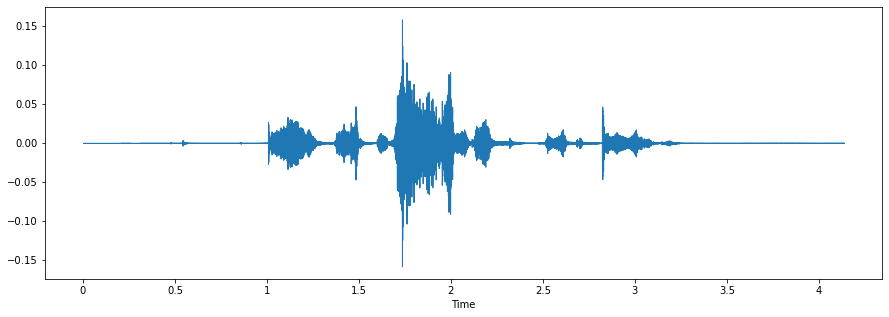

In [16]:
import numpy as np

preEmphasis = 0.97
emphasizedSignal = np.append(X[0], X[1:] - preEmphasis * X[:-1])
print('Emphasized Signal\n', emphasizedSignal)
print('Number of elements:', len(emphasizedSignal))

plt.figure(figsize=(15, 5))
librosa.display.waveshow(emphasizedSignal, sr = samplingRate)
plt.show()

#### Apply Soft-Time Fourier-Transformation (STFT) to the signal

The Short-time Fourier transform (STFT) is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately in each shorter segment. This reveals the Fourier spectrum on each shorter segment.

The parameter **n_fft** is the length of the windowed signal after padding with zeros. The number of rows in the STFT matrix D is (1 + n_fft/2). The default value, n_fft=2048 samples, corresponds to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa. This value is well adapted for music signals. However, in speech processing, the recommended value is 512, corresponding to 23 milliseconds at a sample rate of 22050 Hz.

In [17]:
stft = np.abs(librosa.stft(emphasizedSignal, n_fft = 512))

print('STFT\n', stft)
print('\nSTFT Shape:', stft.shape)

STFT
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.7251832e-05
  3.9635463e-05 1.7816286e-05]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.9780392e-05
  7.5606654e-06 3.2048592e-05]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.8415793e-05
  3.0560906e-05 4.4785582e-05]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.3986405e-10
  1.6158309e-07 2.5879692e-06]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.2882733e-10
  1.6229825e-07 2.5878842e-06]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.2256726e-10
  1.6183600e-07 2.5879510e-06]]

STFT Shape: (257, 713)


#### Extract Mel-frequency cepstral coefficients (MFCCs)

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound.

Even though higher order coefficients represent increasing levels of spectral detail, depending on the sampling rate and estimation method, 12 to 20 cepstral coefficients are typically optimal for speech analysis. The parameter **n_mfcc** is the length of the Fast Fourier Transformation (FFT) window.

*MFCCs are features to be used for our model.*

In [18]:
# Compute MFCCs
mfccs = np.mean(librosa.feature.mfcc(y = emphasizedSignal, sr = samplingRate, n_mfcc = 20).T,axis=0)

print('MFCCs\n', mfccs)
print('\nShape of MFCCs:', mfccs.shape)

MFCCs
 [-689.4513      13.136131   -38.444023    28.491467   -36.779255
    9.32245    -34.116608    -1.4327488  -19.810574     4.656265
  -11.9879     -10.639513     4.917104   -14.493996     1.9685546
  -12.012225     3.0940394  -10.074612    -1.8482265   -6.0479755]

Shape of MFCCs: (20,)


Let us plot the Spectrogram.

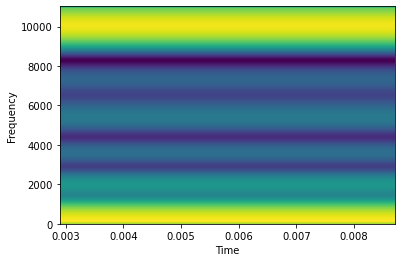

In [19]:
plt.specgram(mfccs, Fs = samplingRate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#### Compute chroma features

In Western music, the term chroma feature or chroma gram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analysing music whose pitches can be meaningfully categorised (often into twelve categories) and whose tuning approximates to equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music while being robust to changes in timbre and instrumentation.

We can extract chroma from speeches to gather information about the pitch.

The parameter **n_fft** is the length of the Fast Fourier Transformation (FFT) window. 

The parameter **hop_length** is the number of samples between successive frames.

*chroma features are features to be used in our model.*

In [20]:
chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = samplingRate,
                                             n_fft = 2048, hop_length = 1024).T, axis = 0)
print('Chroma Features\n', chroma)
print('\nShape of Chroma Features:', chroma.shape)

Chroma Features
 [0.51026803 0.4963213  0.49816346 0.51692945 0.5742091  0.6114398
 0.64996433 0.7051374  0.7605585  0.79590446 0.73575807 0.574072  ]

Shape of Chroma Features: (12,)


Let us plot the Spectrograms.

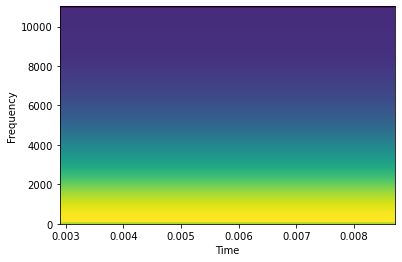

In [21]:
plt.specgram(chroma, Fs = samplingRate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#### Compute Mel Spectrogram

In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the **mel scale**.

*Mel Spectrograms are features for our Model.*

In [22]:
mel = np.mean(librosa.feature.melspectrogram(y = emphasizedSignal, 
                                             sr = samplingRate, 
                                             n_fft = 2048, hop_length = 1024).T,axis=0)
mel = librosa.power_to_db(mel, ref = np.max)
print('Mel Features\n', mel)
print('\nShape of Mel Features:', mel.shape)

Mel Features
 [-62.29589    -55.944923   -51.42813    -49.577095   -36.52014
 -20.505787   -17.008743   -11.825571   -13.846834   -23.155426
 -31.581066   -23.514423   -13.599155   -12.581316    -7.536886
  -4.568012    -7.3826084  -11.508095   -15.077692   -13.694248
 -10.892952    -8.349024    -7.7596455   -8.25111     -8.282166
  -7.4645004  -11.132153   -18.039593   -17.104042   -16.618618
 -14.429581    -9.146317    -2.1230888   -1.833271    -8.294319
 -16.557907   -20.145111   -21.30455    -22.422905   -14.90712
 -13.183041   -13.53274    -10.864588   -17.803444   -21.807007
 -22.206394   -17.357193   -16.585354   -15.534296   -15.985748
 -14.982983   -18.545902   -21.243832   -19.022278   -19.113834
 -18.046383   -20.975574   -23.683514   -20.231289   -17.454521
 -17.251965   -19.933525   -18.916237   -17.384598   -16.033215
 -16.760536   -17.24545    -14.729155   -17.01065    -16.850792
 -18.18747    -22.2695     -22.106583   -18.122662   -20.153107
 -20.045021   -18.92778    -

Let us plot the Spectrogram.

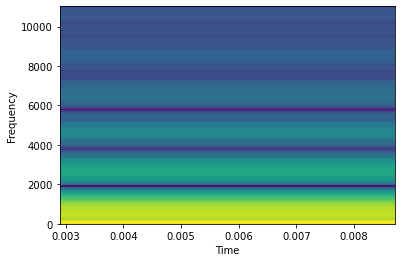

In [23]:
plt.specgram(mel, Fs = samplingRate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#### Function to collect all the features from an audio clip

Now that we have discussed what features we could collect from the Audio Clips, let us write a function to collect all the features from an Audio Clip.

In [24]:
def extractFeatures(fileName):
    features = np.array([]) # Variable to store all the features
    
    # Load the Audio Clip
    X, samplingRate = librosa.load(fileName)
    
    # Pre Emphasise
    preEmphasis = 0.97
    emphasizedSignal = np.append(X[0], X[1:] - preEmphasis * X[:-1])
    
    # Apply Soft-Time Fourier-Transformation (STFT) to the signal
    stft = np.abs(librosa.stft(emphasizedSignal, n_fft = 512))
    
    # Compute mfcc and collect features
    mfccs = np.mean(librosa.feature.mfcc(y = emphasizedSignal, sr = samplingRate, n_mfcc = 20).T,axis=0)
    features = np.hstack((features, mfccs))
    
    # Compute chroma features and collect features
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = samplingRate,
                                                 n_fft = 2048, hop_length = 1024).T, axis = 0)
    features = np.hstack((features, chroma))

    # Compute melspectrogram and collect features
    mel = np.mean(librosa.feature.melspectrogram(y = emphasizedSignal, 
                                                 sr = samplingRate, 
                                                 n_fft = 2048, hop_length = 1024).T,axis=0)
    mel = librosa.power_to_db(mel, ref = np.max)
    features = np.hstack((features, mel))

    return features

Let us test our function to collect features from our sample Audio Clip

In [25]:
features = extractFeatures(sampleAudio1)
print('Features\n', features)
print('\nNumber of Features:', len(features))

Features
 [-6.89451294e+02  1.31361313e+01 -3.84440231e+01  2.84914665e+01
 -3.67792549e+01  9.32244968e+00 -3.41166077e+01 -1.43274879e+00
 -1.98105736e+01  4.65626478e+00 -1.19878998e+01 -1.06395130e+01
  4.91710377e+00 -1.44939957e+01  1.96855462e+00 -1.20122252e+01
  3.09403944e+00 -1.00746117e+01 -1.84822655e+00 -6.04797554e+00
  5.10268033e-01  4.96321291e-01  4.98163462e-01  5.16929448e-01
  5.74209094e-01  6.11439824e-01  6.49964333e-01  7.05137372e-01
  7.60558486e-01  7.95904458e-01  7.35758066e-01  5.74072003e-01
 -6.22958908e+01 -5.59449234e+01 -5.14281311e+01 -4.95770950e+01
 -3.65201416e+01 -2.05057869e+01 -1.70087433e+01 -1.18255711e+01
 -1.38468342e+01 -2.31554260e+01 -3.15810661e+01 -2.35144234e+01
 -1.35991554e+01 -1.25813160e+01 -7.53688622e+00 -4.56801224e+00
 -7.38260841e+00 -1.15080948e+01 -1.50776920e+01 -1.36942482e+01
 -1.08929520e+01 -8.34902382e+00 -7.75964546e+00 -8.25111008e+00
 -8.28216553e+00 -7.46450043e+00 -1.11321526e+01 -1.80395927e+01
 -1.71040421e+0

#### Extracting features from all the Audio Clips

Now that we have the function to extract features from Audio Clips, we extract the features from all the Audio Clips.

In [26]:
!pip -qq install tqdm

In [27]:
from tqdm import tqdm

def extractFeaturesFromFiles(files):
    X = []
    for file in tqdm(files):
        features = extractFeatures(file)

        X.append(features)
        
    return X

XTess = extractFeaturesFromFiles(tessFiles)
XRavdess = extractFeaturesFromFiles(ravdessFiles)

100%|██████████| 1168/1168 [00:21<00:00, 54.54it/s]


**Now we combine the 2 sets of features (one obtained from the Tess files and one obtained from the Ravdess files) to a single list.**

In [28]:
X = np.vstack((XTess, XRavdess))

print('Shape of X:', X.shape)

Shape of X: (3847, 160)


#### Converting the labels to numbers

We have the labels for the files in the dataframe dfCombined. However, the labels are stored as strings. We cannot use these strings to train a model. We need to convert these strings to numbers. We will use a **LabelEncoder** to convert these string labels to numeric labels.

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dfCombined['EmotionLabel'] = le.fit_transform(dfCombined['Emotion'])

y = dfCombined['EmotionLabel']

### Creating a Bagging Classification Model

We will create a multi-class Bagging Classification Model.

#### Create the Training Set and Test Set

First we have to create the training set on which the model will be created and the test set which will be used to test the model.

In [30]:
from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.05, random_state = 42)

print('XTrain - Shape:', XTrain.shape, ' XTest - Shape:', XTest.shape)
print('yTrain - Shape:', yTrain.shape, ' yTest - Shape:', yTest.shape)

XTrain - Shape: (3654, 160)  XTest - Shape: (193, 160)
yTrain - Shape: (3654,)  yTest - Shape: (193,)


### Create a Model

Now, we create the Bagging Classifier Model on the Training set.

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bc = BaggingClassifier(base_estimator = DecisionTreeClassifier(), 
                       n_estimators = 10, 
                       oob_score = True,
                       random_state = 42)

bc.fit(XTrain, yTrain)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), oob_score=True,
                  random_state=42)

#### Check the Prediction on the Training Set

We make the predictions using the model on the training set and check the metrics.

For the metrics, we will check the accuracy score, precision, recall and f-score.

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make the predictions
yPredTrain = bc.predict(XTrain)

# Compute the metrics
accuracy = accuracy_score(yTrain, yPredTrain)
precision = precision_score(yTrain, yPredTrain, average = 'weighted')
recall = recall_score(yTrain, yPredTrain, average = 'weighted')
f1Score = f1_score(yTrain, yPredTrain, average = 'weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1Score)

Accuracy: 0.9956212370005474
Precision: 0.9956359773638089
Recall: 0.9956212370005474
F1 Score: 0.9956214486226791


#### Check the Prediction on the Test Set

We now make the predictions on the Test Set and check the metrics.

In [33]:
# Make the predictions
yPredTest = bc.predict(XTest)

# Compute the metrics
accuracy = accuracy_score(yTest, yPredTest)
precision = precision_score(yTest, yPredTest, average = 'weighted')
recall = recall_score(yTest, yPredTest, average = 'weighted')
f1Score = f1_score(yTest, yPredTest, average = 'weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1Score)

Accuracy: 0.8238341968911918
Precision: 0.8273995176996665
Recall: 0.8238341968911918
F1 Score: 0.8245289984658447


**We can see that the Training Accuracy is 99.56%. Whereas the Test Accuracy is 82.38%. Clearly the model is overfitting. Nevertheless, the model will still be capable of giving reasonable predictions.**

### Validating the Model on Live Data

The purpose of building the model is to make predictions on live data. For this purpose, I demonstrate the mechanics using the Test Dataset provided by Kaggle. The following code loads the Kaggle Test Data and makes predictions on the same.

In [34]:
#!unzip -qq Kaggle_Testset.zip

In [35]:
# Set the model to Random Forest Model we just developed
MODEL = bc

# Load the Kaggle Files
kaggleFiles = glob.glob('./Kaggle_Testset/Kaggle_Testset/*.wav', recursive = False)

# Extract features from the Kaggle Files
XKaggle = extractFeaturesFromFiles(kaggleFiles)

# Make predictions for the emotions in the Kaggle Files
dfKaggle = pd.DataFrame(columns = ['Id', 'Label'])
predKaggle = MODEL.predict(XKaggle)
predictedEmotions = le.inverse_transform(predKaggle)
for ctr in range(len(kaggleFiles)):
    fileNumber = kaggleFiles[ctr].split("/")[-1].split(".")[0]
    dfKaggle = dfKaggle.append({'Id':fileNumber, 'Label':predictedEmotions[ctr]}, ignore_index=True)

print(dfKaggle.head())

100%|██████████| 201/201 [00:02<00:00, 67.23it/s]


    Id    Label
0   16    happy
1  103  neutral
2  117    angry
3  116  neutral
4  102  disgust
